# 폰트 분류 프로젝트

In [1]:
# 필요한 패키지 임포트
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Rescaling

from keras.applications import vgg16

#from keras.layers.


## 데이터셋 생성

In [12]:
# 자음, 모음을 결합하여 만들 수 있는 2350가지의 글자를 한 줄씩 담은 txt파일을 load
# 한 줄씩 읽어와서 리스트로 만듦
charset = [c.strip() for c in open('2350-common-hangul.txt','r',encoding='utf-8').readlines()]

# 폰트 데이터가 저장된 경로
FONT_PATH = './fonts'

# 데이터셋이 저장될 경로
OUTPUT_PATH = './datasets'

# 이미지 크기 및 글자 크기 설정
canvas_size = 128
font_size = 80


if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

    
fontList = os.listdir(FONT_PATH)
total_cnt = 0

for label, f in enumerate(fontList):
    if not os.path.exists(f'{OUTPUT_PATH}/{label}'):
        os.mkdir(f'{OUTPUT_PATH}/{label}')
    for cnt, c in enumerate(charset):
        # 3채널로 이미지 생성
        image = Image.new('RGB', (canvas_size, canvas_size), color=(255,255,255))
        drawing = ImageDraw.Draw(image)
        font = ImageFont.truetype(os.path.join(FONT_PATH, f), size=font_size)
        w, h = drawing.textsize(c, font=font)
        drawing.text( ((canvas_size-w)/2, (canvas_size-h)/2), c, fill=(0), font=font)
        image.save(os.path.join(f'{OUTPUT_PATH}/{label}',f"{cnt:04d}.jpg"))
        if cnt % 100 == 0:
            print(f"processed {label}\'s {cnt} chars")
    print(f"{label}번째 font data 생성 완료")

processed 0's 0 chars
processed 0's 100 chars
processed 0's 200 chars
processed 0's 300 chars
processed 0's 400 chars
processed 0's 500 chars
processed 0's 600 chars
processed 0's 700 chars
processed 0's 800 chars
processed 0's 900 chars
processed 0's 1000 chars
processed 0's 1100 chars
processed 0's 1200 chars
processed 0's 1300 chars
processed 0's 1400 chars
processed 0's 1500 chars
processed 0's 1600 chars
processed 0's 1700 chars
processed 0's 1800 chars
processed 0's 1900 chars
processed 0's 2000 chars
processed 0's 2100 chars
processed 0's 2200 chars
processed 0's 2300 chars
0번째 font data 생성 완료
processed 1's 0 chars
processed 1's 100 chars
processed 1's 200 chars
processed 1's 300 chars
processed 1's 400 chars
processed 1's 500 chars
processed 1's 600 chars
processed 1's 700 chars
processed 1's 800 chars
processed 1's 900 chars
processed 1's 1000 chars
processed 1's 1100 chars
processed 1's 1200 chars
processed 1's 1300 chars
processed 1's 1400 chars
processed 1's 1500 chars
proc

## data load & train test split

In [2]:
# 매개변수 설정
data_dir='./datasets'
batch_size = 32
img_height = 128
img_width = 128

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 11750 files belonging to 5 classes.
Using 9400 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11750 files belonging to 5 classes.
Using 2350 files for validation.


## 데이터 증강 레이어

In [6]:
data_augmentation = Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, input_shape=(128, 128, 3)),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.9),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

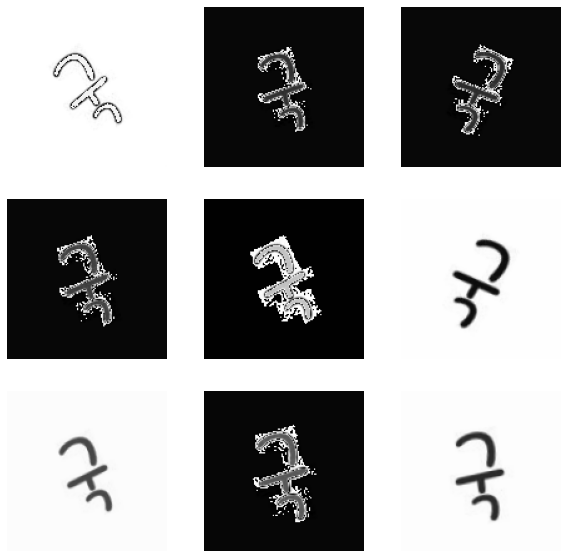

In [7]:
# data_augmentation 함수 적용한 이미지 9개 출력
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
        #print(np.shape(augmented_images))

## user 모델

In [8]:
user_model=Sequential()
user_model.add(data_augmentation)
user_model.add(Conv2D(32, kernel_size = (3,3), activation='relu'))
user_model.add(MaxPooling2D(pool_size=2))
user_model.add(Conv2D(128, kernel_size = (3,3), activation='relu'))
user_model.add(MaxPooling2D(pool_size=2))
user_model.add(Dropout(0.3))
user_model.add(Conv2D(32, kernel_size = (3,3), activation='relu'))
user_model.add(Flatten())
user_model.add(Dense(64, activation='relu'))
user_model.add(Dense(5, activation='softmax', name='output'))

user_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy('sparse_categorical_crossentropy'),
                   optimizer='adam', metrics=['accuracy'])
user_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)       

In [9]:
u_hist = user_model.fit(train_ds, validation_data = val_ds, epochs=30)

Epoch 1/30


C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


294/294 [==============================] - 15s 26ms/step - loss: 3.7467 - accuracy: 0.2715 - val_loss: 1.5358 - val_accuracy: 0.2638
Epoch 2/30
294/294 [==============================] - 7s 24ms/step - loss: 1.4403 - accuracy: 0.3484 - val_loss: 1.2079 - val_accuracy: 0.4374
Epoch 3/30
294/294 [==============================] - 7s 24ms/step - loss: 1.2507 - accuracy: 0.4309 - val_loss: 0.8760 - val_accuracy: 0.5736
Epoch 4/30
294/294 [==============================] - 7s 24ms/step - loss: 1.0483 - accuracy: 0.5145 - val_loss: 0.7908 - val_accuracy: 0.5962
Epoch 5/30
294/294 [==============================] - 7s 24ms/step - loss: 0.9501 - accuracy: 0.5467 - val_loss: 0.7882 - val_accuracy: 0.5694
Epoch 6/30
294/294 [==============================] - 7s 24ms/step - loss: 0.8537 - accuracy: 0.5879 - val_loss: 0.7355 - val_accuracy: 0.5885
Epoch 7/30
294/294 [==============================] - 7s 24ms/step - loss: 0.8982 - accuracy: 0.5929 - val_loss: 0.7164 - val_accuracy: 0.6851
Epoch 8/3

## acc & loss 그래프

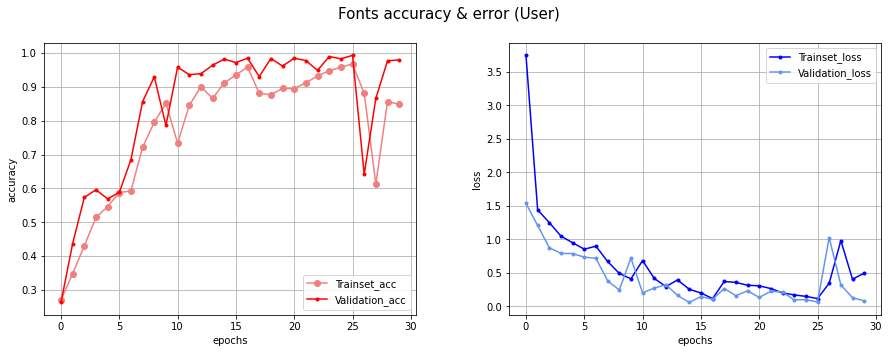

In [20]:
# 1행 2열로 그래프 출력. 

row=1
col=2

f, axes = plt.subplots(row, col)
f.set_size_inches((15,5)) 
plt.subplots_adjust(wspace = 0.25, hspace = 0.45)

acc = u_hist.history['accuracy']
loss = u_hist.history['loss']
val_acc= u_hist.history['val_accuracy']
val_loss = u_hist.history['val_loss']

x_len=range(len(loss))

# figure 전체 제목
f.suptitle('Fonts accuracy & error (User)', fontsize = 15)

axes[0].plot(x_len, acc, marker='o', c="lightcoral", label='Trainset_acc')
axes[0].plot(x_len, val_acc, marker='.', c='red', label='Validation_acc')
axes[0].legend(loc='lower right')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].grid(True)


# 일반 acc, loss
axes[1].plot(x_len, loss, marker='.', c="blue", label='Trainset_loss')
axes[1].plot(x_len, val_loss, marker='.', c='cornflowerblue', label='Validation_loss')
axes[1].legend(loc='upper right')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].grid(True)

plt.show()

## vgg 모델

In [15]:
#inputs = Rescaling(1./255, input_shape=(128, 128, 3))

transfer_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
transfer_model.trainable = False

vgg_model=Sequential()
vgg_model.add(data_augmentation)
vgg_model.add(transfer_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(64, activation='relu'))
vgg_model.add(Dense(5, activation='softmax', name='output'))

vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [13]:
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                524352    
_________________________________________________________________
output (Dense)               (None, 5)                 325       
Total params: 15,239,365
Trainable params: 524,677
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
v_hist = vgg_model.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
294/294 [==============================] - 16s 50ms/step - loss: 0.3715 - accuracy: 0.8946 - val_loss: 0.3504 - val_accuracy: 0.8536
Epoch 2/30
294/294 [==============================] - 14s 46ms/step - loss: 0.1256 - accuracy: 0.9537 - val_loss: 0.2161 - val_accuracy: 0.9217
Epoch 3/30
294/294 [==============================] - 14s 48ms/step - loss: 0.0882 - accuracy: 0.9685 - val_loss: 0.1568 - val_accuracy: 0.9438
Epoch 4/30
294/294 [==============================] - 14s 48ms/step - loss: 0.0939 - accuracy: 0.9657 - val_loss: 0.1226 - val_accuracy: 0.9587
Epoch 5/30
294/294 [==============================] - 14s 49ms/step - loss: 0.0751 - accuracy: 0.9728 - val_loss: 0.2769 - val_accuracy: 0.8949
Epoch 6/30
294/294 [==============================] - 14s 48ms/step - loss: 0.0610 - accuracy: 0.9785 - val_loss: 0.3025 - val_accuracy: 0.9187
Epoch 7/30
294/294 [==============================] - 14s 48ms/step - loss: 0.0813 - accuracy: 0.9715 - val_loss: 0.1635 - val_accuracy:

## acc & loss 그래프 (vgg)

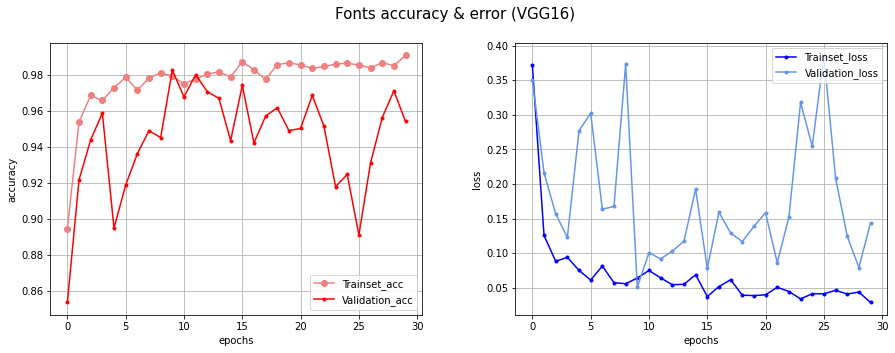

In [19]:
# 1행 2열로 출력

row=1
col=2

f, axes = plt.subplots(row, col)
f.set_size_inches((15,5))
plt.subplots_adjust(wspace = 0.25, hspace = 0.45)

acc = v_hist.history['accuracy']
loss = v_hist.history['loss']
val_acc= v_hist.history['val_accuracy']
val_loss = v_hist.history['val_loss']

x_len=range(len(loss))

# figure 전체 제목
f.suptitle('Fonts accuracy & error (VGG16)', fontsize = 15)

axes[0].plot(x_len, acc, marker='o', c="lightcoral", label='Trainset_acc')
axes[0].plot(x_len, val_acc, marker='.', c='red', label='Validation_acc')
axes[0].legend(loc='lower right')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].grid(True)


# 일반 acc, loss
axes[1].plot(x_len, loss, marker='.', c="blue", label='Trainset_loss')
axes[1].plot(x_len, val_loss, marker='.', c='cornflowerblue', label='Validation_loss')
axes[1].legend(loc='upper right')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].grid(True)


plt.show()

## 결과 정리

In [21]:
# user_model
# training
# 가장 높은 정확도
max_acc = np.max(u_hist.history['accuracy'])
macc_epoch = u_hist.history['accuracy'].index(max_acc) # 제일 높은 acc가 나온 반복 횟수
# 가장 낮은 로스
min_loss = np.min(u_hist.history['loss'])
mloss_epoch = u_hist.history['loss'].index(min_loss)

# validation
# 가장 높은 정확도
t_max_acc = np.max(u_hist.history['val_accuracy'])
t_macc_epoch = u_hist.history['val_accuracy'].index(t_max_acc) # 제일 높은 acc가 나온 반복 횟수
# 가장 낮은 로스
t_min_loss = np.min(u_hist.history['val_loss'])
t_mloss_epoch = u_hist.history['val_loss'].index(t_min_loss)

print('사용자 모델')
print('training best acc: {} (epoch: {}) \ntraining best loss {} (epoch: {})'.format(max_acc, macc_epoch, min_loss, mloss_epoch))
print('test best acc: {} (epoch: {}) \ntest best loss {} (epoch: {})'.format(t_max_acc, t_macc_epoch, t_min_loss, t_mloss_epoch))


# validation
# training
# 가장 높은 정확도
max_acc = np.max(v_hist.history['accuracy'])
macc_epoch =v_hist.history['accuracy'].index(max_acc) # 제일 높은 acc가 나온 반복 횟수
# 가장 낮은 로스
min_loss = np.min(v_hist.history['loss'])
mloss_epoch = v_hist.history['loss'].index(min_loss)

# validation
# 가장 높은 정확도
t_max_acc = np.max(v_hist.history['val_accuracy'])
t_macc_epoch = v_hist.history['val_accuracy'].index(t_max_acc) # 제일 높은 acc가 나온 반복 횟수
# 가장 낮은 로스
t_min_loss = np.min(v_hist.history['val_loss'])
t_mloss_epoch = v_hist.history['val_loss'].index(t_min_loss)

print('사용자 모델')
print('training best acc: {} (epoch: {}) \ntraining best loss {} (epoch: {})'.format(max_acc, macc_epoch, min_loss, mloss_epoch))
print('test best acc: {} (epoch: {}) \ntest best loss {} (epoch: {})'.format(t_max_acc, t_macc_epoch, t_min_loss, t_mloss_epoch))


사용자 모델
training best acc: 0.9673404097557068 (epoch: 25) 
training best loss 0.11661850661039352 (epoch: 25)
test best acc: 0.9927659630775452 (epoch: 25) 
test best loss 0.05870465189218521 (epoch: 14)
사용자 모델
training best acc: 0.9907447099685669 (epoch: 29) 
training best loss 0.028692392632365227 (epoch: 29)
test best acc: 0.9825531840324402 (epoch: 9) 
test best loss 0.05088259279727936 (epoch: 9)


In [22]:
# user_model
# training
# 가장 높은 정확도
max_acc = np.max(u_hist.history['accuracy'])
macc_epoch = u_hist.history['accuracy'].index(max_acc) # 제일 높은 acc가 나온 반복 횟수
# 가장 낮은 로스
min_loss = np.min(u_hist.history['loss'])
mloss_epoch = u_hist.history['loss'].index(min_loss)

# validation
# 가장 높은 정확도
t_max_acc = np.max(u_hist.history['val_accuracy'])
t_macc_epoch = u_hist.history['val_accuracy'].index(t_max_acc) # 제일 높은 acc가 나온 반복 횟수
# 가장 낮은 로스
t_min_loss = np.min(u_hist.history['val_loss'])
t_mloss_epoch = u_hist.history['val_loss'].index(t_min_loss)

print('사용자 모델')
print('training best acc: {:0.4f} (epoch: {}) \ntraining best loss {:0.4f} (epoch: {})'.format(max_acc, macc_epoch, min_loss, mloss_epoch))
print('validation best acc: {:0.4f} (epoch: {}) \nvalidation best loss {:0.4f} (epoch: {})'.format(t_max_acc, t_macc_epoch, t_min_loss, t_mloss_epoch))
print()

# validation
# training
# 가장 높은 정확도
max_acc = np.max(v_hist.history['accuracy'])
macc_epoch =v_hist.history['accuracy'].index(max_acc) # 제일 높은 acc가 나온 반복 횟수
# 가장 낮은 로스
min_loss = np.min(v_hist.history['loss'])
mloss_epoch = v_hist.history['loss'].index(min_loss)


# validation
# 가장 높은 정확도
t_max_acc = np.max(v_hist.history['val_accuracy'])
t_macc_epoch = v_hist.history['val_accuracy'].index(t_max_acc) # 제일 높은 acc가 나온 반복 횟수
# 가장 낮은 로스
t_min_loss = np.min(v_hist.history['val_loss'])
t_mloss_epoch = v_hist.history['val_loss'].index(t_min_loss)

print('VGG 모델')
print('training best acc: {:0.4f} (epoch: {}) \ntraining best loss {:0.4f} (epoch: {})'.format(max_acc, macc_epoch, min_loss, mloss_epoch))
print('validation best acc: {:0.4f} (epoch: {}) \nvalidation best loss {:0.4f} (epoch: {})'.format(t_max_acc, t_macc_epoch, t_min_loss, t_mloss_epoch))


사용자 모델
training best acc: 0.9673 (epoch: 25) 
training best loss 0.1166 (epoch: 25)
validation best acc: 0.9928 (epoch: 25) 
validation best loss 0.0587 (epoch: 14)

VGG 모델
training best acc: 0.9907 (epoch: 29) 
training best loss 0.0287 (epoch: 29)
validation best acc: 0.9826 (epoch: 9) 
validation best loss 0.0509 (epoch: 9)
